# Semidefinite Relaxation of AC Optimal Power Flow Problems

This notebook demonstrates the use of semidefinite relaxation techniques for AC optimal power flow (ACOPF) problems. A description of the problem formulation and its implementation can be found in the following paper:

> M. S. Andersen, A. Hansson, L. Vandenberghe, "[Reduced-Complexity Semidefinite Relaxations of Optimal Power Flow Problems](https://doi.org/10.1109/TPWRS.2013.2294479)", IEEE Transactions on Power Systems, 29 (4), pp. 1855–1863, 2014.

To run this notebook, you will need [CVXOPT](http://cvxopt.org), [CHOMPACK](https://cvxopt.github.io/chompack), [MOSEK](https://www.mosek.com), and [Matplotlib](http://matplotlib.org).

## Test cases

[MATPOWER](https://github.com/MATPOWER/matpower) provides a number of test cases that are basically MATLAB m-files, most of which (those that do not perform any computations) can be loaded directly from a file or from a url. For example, the following code
```
from opfsdr import opf
prob = opf('https://github.com/MATPOWER/matpower/blob/master/data/case300.m')
```
downloads the `case300` test case from the MATPOWER repository on Github and generates a semidefinite relaxation problem. Alternatively, using the [Github API](https://developer.github.com/v3/), a list of test cases and their urls can be retrieved from the MATPOWER repository as follows:

In [1]:
import json, re
import requests
testcases = {}
clist = []

# Retrieve list of MATPOWER test cases
response = requests.get('https://api.github.com/repos/MATPOWER/matpower/contents/data')
clist += json.loads(response.text)

# Retrieve list of pglib-opf test cases
response = requests.get('https://api.github.com/repos/power-grid-lib/pglib-opf/contents/')
clist += json.loads(response.text)
response = requests.get('https://api.github.com/repos/power-grid-lib/pglib-opf/contents/api')
clist += json.loads(response.text)
response = requests.get('https://api.github.com/repos/power-grid-lib/pglib-opf/contents/sad')
clist += json.loads(response.text)

# Build list of test cases
for c in clist:
    if not c['name'].endswith('.m'): continue
    casename = c['name'].split('.')[0]
    testcases[casename] = c['download_url']

## Building and solving ACOPFs

The following example illustrates how to use `opfsdr` to download a test case, form a semidefinite relaxation problem, and how solve this problem:

In [2]:
from opfsdr import opf

#case = 'pglib_opf_case1354_pegase__sad'
case = 'case1354pegase'
print("Test case: %s" % case)
options = {'conversion': True,          # apply chordal conversion? (default: False)
           'tfill': 16,                 #   use clique merging heuristic based on fill (default: 0)
           'tsize': 0,                  #   use clique merging heuristic based on clique size (default: 0)
           'branch_rmin': 1e-5,         # minimum transmission line resistance (default: -inf)
           'line_constraints': True,    # include apparent power flow constraints in problem formulation
           'pad_constraints': True,     # include phase angle difference constraints
           'truncate_gen_bounds': 1e3,  # reduce large generator bounds (default: None)
           'verbose': 1,                # print info, progress, etc. (default: 0)
           'scale': False               # apply scaling heuristic to cone LP? (default: False)
          }

%time prob = opf(testcases[case], **options)

print(prob)

Test case: case1354pegase
Extracting data from case file.
Building cone LP.
Applying chordal conversion to cone LP.
Converting to real-valued cone LP.
CPU times: user 1.24 s, sys: 131 ms, total: 1.37 s
Wall time: 1.59 s
Optimal power flow problem
* busses             :   1354
* generators         :    260
   -  const. gen.    :      0
   -  lin. cost      :    260
   -  quad. cost     :      0
* branches           :   1991
   -  flow constr.   :   1432
   -  phase constr.  :      0
   -  transformer    :    234


The semidefinite relaxation can be solved with MOSEK as follows:

In [3]:
# Solve semidefinite relaxation
%time sol = prob.solve(solver="mosek")

Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 17345           
  Cones                  : 2864            
  Scalar variables       : 12340           
  Matrix variables       : 233             
  Integer variables      : 0               

Optimizer started.
Presolve started.
Linear dependency checker started.
Linear dependency checker terminated.
Eliminator - tries                  : 0                 time                   : 0.00            
Lin. dep.  - tries                  : 1                 time                   : 0.01            
Lin. dep.  - number                 : 0               
Presolve terminated. Time: 0.02    
Problem
  Name                   :                 
  Objective sense        : max             
  Type                   : CONIC (conic optimization problem)
  Constraints            : 17345           
  Cones               

66  2.1e-07  2.6e-05  1.9e-04  1.00e+00   -5.097875422e+02  -5.097875707e+02  1.0e-07  11.68 
67  8.4e-08  1.1e-05  1.2e-04  1.00e+00   -5.100550584e+02  -5.100550707e+02  4.2e-08  11.81 
68  6.2e-08  7.9e-06  1.0e-04  1.00e+00   -5.101041749e+02  -5.101041841e+02  3.1e-08  11.94 
69  1.1e-08  1.4e-06  4.2e-05  1.00e+00   -5.102177528e+02  -5.102177547e+02  5.6e-09  12.08 
Optimizer terminated. Time: 12.11   


Interior-point solution summary
  Problem status  : PRIMAL_AND_DUAL_FEASIBLE
  Solution status : OPTIMAL
  Primal.  obj: -5.1021775282e+02   nrm: 2e+03    Viol.  con: 2e-03    var: 2e-04    barvar: 0e+00    cones: 0e+00  
  Dual.    obj: -5.1021776748e+02   nrm: 4e+03    Viol.  con: 0e+00    var: 1e-08    barvar: 5e-07    cones: 1e-08  
CPU times: user 21.2 s, sys: 1.43 s, total: 22.6 s
Wall time: 12.8 s


In [4]:
print("Solver status: %s" % sol['status'])

Solver status: optimal


The objective value associated with the semidefinite relaxation does not include constant cost, and hence it is not necessarily equal to the cost of generation: the cost of generation is available as `sol['cost']`: 

In [5]:
print("Generation cost: %.2f USD/hour (fixed cost: %.2f USD/hour)"%(sol['cost'],prob.const_cost))

Generation cost: 74059.47 USD/hour (fixed cost: 23037.69 USD/hour)


## Eigenvalue ratio(s)

Populating the interactive namespace from numpy and matplotlib
Cliques with eigenvalue ratio less than 1e5: 5 of 233


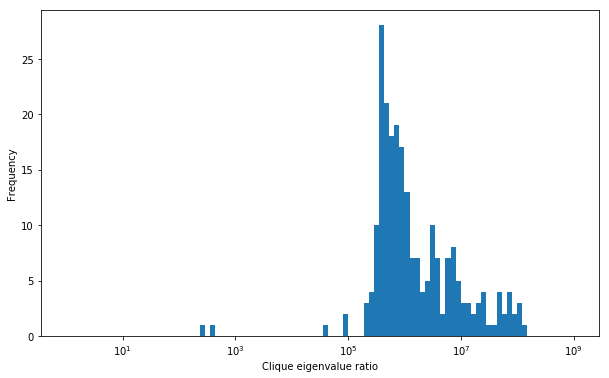

In [6]:
%pylab inline
from pylab import plot,xlabel,ylabel,arange,linspace,hist,xscale,rcParams
rcParams['figure.figsize'] = (10, 6)

if len(sol['eigratio']) == 1:
    print("Eigenvalue ratio: %.2e" % (sol['eigratio'][0]))
else:
    import numpy as np
    hist(sol['eigratio'],bins=[10.**a for a in linspace(0,9,100)])
    xscale('log')
    xlabel('Clique eigenvalue ratio')
    ylabel('Frequency')
    print("Cliques with eigenvalue ratio less than 1e5: %i of %i"\
          % (len([1 for evr in sol['eigratio'] if evr < 1e5]),len(sol['eigratio'])))

## Generation

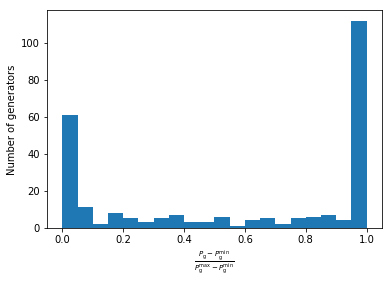

In [7]:
pmin = np.array([gen['Pmin'] for gen in prob.generators])*prob.baseMVA
pmax = np.array([gen['Pmax'] for gen in prob.generators])*prob.baseMVA
hist((np.array(sol['Sg'].real().T).squeeze()-pmin)/(pmax-pmin),20)
xlabel(r'$\frac{P_{\mathrm{g}}-P_{\mathrm{g}}^{\min}}{P_{\mathrm{g}}^{\max} - P_{\mathrm{g}}^{\min}}$')
ylabel('Number of generators');

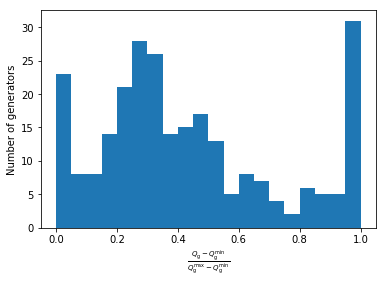

In [8]:
pmin = np.array([gen['Qmin'] for gen in prob.generators])*prob.baseMVA
pmax = np.array([gen['Qmax'] for gen in prob.generators])*prob.baseMVA
hist((np.array(sol['Sg'].imag().T).squeeze()-pmin)/(pmax-pmin),20)
xlabel(r'$\frac{Q_{\mathrm{g}}-Q_{\mathrm{g}}^{\min}}{Q_{\mathrm{g}}^{\max} - Q_{\mathrm{g}}^{\min}}$')
ylabel('Number of generators');

## Voltage magnitude constraints

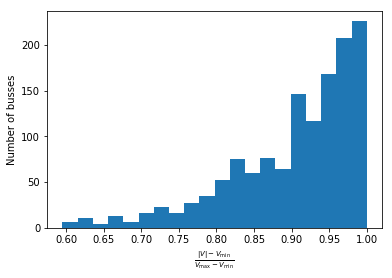

In [9]:
minvm = np.array([b['minVm'] for b in prob.busses])
maxvm = np.array([b['maxVm'] for b in prob.busses])
hist((np.array(sol['Vm']).squeeze()-minvm)/(maxvm-minvm),20)
xlabel(r'$\frac{|V| - V_{\min}}{V_{\max}-V_{\min}}$')
ylabel('Number of busses');

## Flow constraints

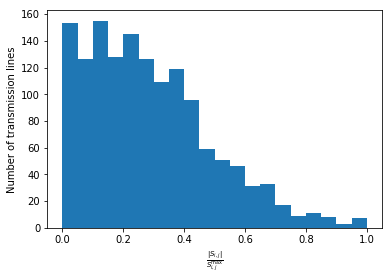

In [10]:
if prob.branches_with_flow_constraints():
    Sapp = np.array(abs(sol['St'])).squeeze()
    Smax = np.array([br['rateA'] for _,br in prob.branches_with_flow_constraints()])
    hist(Sapp/Smax,20)
    
    pyplot.xlabel(r'$\frac{|S_{i,j}|}{S_{i,j}^{\max}}$')
    pyplot.ylabel('Number of transmission lines')
else:
    print("No flow constraints.")